# Previsão de preço de ações usando LSTM

- Os preços no mercado de ações exibem imprevisibilidade e alta volatilidade. Isso implica que não existem padrões consistentes nos dados que permitam uma modelagem praticamente perfeita dos preços das ações ao longo do tempo.

## 1. Problema de Negócio

- Imagine que você é um investidor novato e deseja obter informações sobre se os preços das ações vão se valorizar ou desvalorizar em um período próximo.


- Você decide desenvolver um modelo de previsão de preço de fechamento para as ações da MAGAZINE LUIZA (MGLU3), com a capacidade de estimar os preços até 10 dias no futuro, utilizando uma rede LSTM (Long Short-Term Memory).


- Você opta por adquirir informações de cotações de ações no Yahoo Finance utilizando Python em um intervalo de tempo definido e, posteriormente, conduzir análises com base nesses dados.

## 2. Importar bibliotecas e conjunto de dados

- Existem várias abordagens para coletar cotações de ações do Yahoo Finance com Python. Neste projeto, faremos uso das bibliotecas pandas_datareader e yfinance.

In [1]:
# Importando as bibliotecas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as pdr
import yfinance as yf

# Ajustar o pandas-datareader utilizando a biblioteca yfinance para resolver problemas (bugs).

yf.pdr_override()


In [2]:
# Obtendo dados da Magazine Luiza

data_inicial = "2014-01-01"
data_final = "2023-11-07"
mglu = pdr.get_data_yahoo("MGLU3.SA", data_inicial, data_final)
mglu

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,0.237812,0.244375,0.217187,0.225937,0.203836,40896000
2014-01-03,0.228125,0.234062,0.220937,0.233437,0.210603,25686400
2014-01-06,0.234375,0.246875,0.234062,0.245625,0.221599,19190400
2014-01-07,0.246875,0.258437,0.246875,0.251875,0.227237,40121600
2014-01-08,0.251250,0.257500,0.250312,0.256875,0.231748,25312000
...,...,...,...,...,...,...
2023-10-30,1.460000,1.470000,1.350000,1.370000,1.370000,79975400
2023-10-31,1.370000,1.380000,1.330000,1.330000,1.330000,145094800
2023-11-01,1.330000,1.360000,1.310000,1.330000,1.330000,138930300


### Metadados:

>  - Open: Abertura do preço das ações do dia
>  - High: maior preço das ações do dia
>  - Low: Menor preço das ações do dia
>  - Close: Preço de fechamento das ações do dia
>  - Adj Close: Preço de fechamento ajustado das ações do dia
>  - Volume: número de ativos que foram comprados e vendidos no dia  

## 3. Exploração de Dados

In [3]:
mglu.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2448 entries, 2014-01-02 to 2023-11-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2448 non-null   float64
 1   High       2448 non-null   float64
 2   Low        2448 non-null   float64
 3   Close      2448 non-null   float64
 4   Adj Close  2448 non-null   float64
 5   Volume     2448 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 133.9 KB


- Os dados estão organizados cronologicamente por data (a ordem dos dados é fundamental na modelagem de séries temporais).


###  Visualização de dados

- Vamos utilizar o preço de fechamento e uma média móvel de 30 dias para analisar o comportamento dos preços das ações ao longo do tempo.

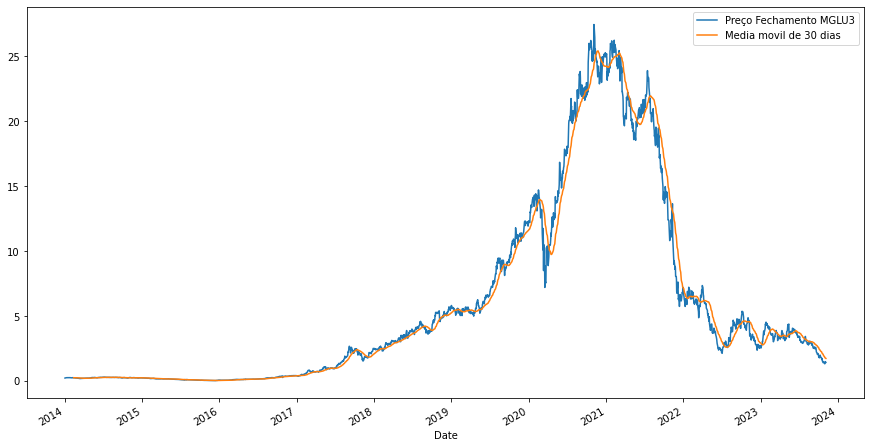

In [4]:
mglu["Close"].plot(legend=True, label="Preço Fechamento MGLU3", figsize=(15,8))
mglu["Close"].rolling(30).mean().plot(legend=True, label="Media movil de 30 dias", figsize=(15,8));

- No momento, os preços do ativo estão em queda, o que é confirmado pela tendência descendente dela média móvel.

# 4. Modelagem

- O modelo será treinado usando o preço de fechamento do ativo.

In [5]:
mglu_fechamento = mglu[["Close"]]
mglu_fechamento

,Close
Date,
2014-01-02,0.225937
2014-01-03,0.233437
2014-01-06,0.245625
2014-01-07,0.251875
2014-01-08,0.256875
...,...
2023-10-30,1.370000
2023-10-31,1.330000
2023-11-01,1.330000


## 4.1 Pré-processamento de dados 

### Verificar a quantidade de linhas

In [6]:
qtd_linhas = len(mglu_fechamento)
qtd_treino = round(0.70*qtd_linhas)
qtd_teste = qtd_linhas - qtd_treino

qtd_treino, qtd_teste


(1714, 734)

- Vamos alocar 70% dos dados para o conjunto de treinamento, reservando as 30% restantes, que correspondem às últimas 734 linhas do conjunto de dados, para o conjunto de teste.

### Normalizando os dados

- As redes neurais LSTM  são sensíveis à escala dos dados de entrada, particularmente quando se utilizam funções de ativação como sigmoid ou tanh.

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
mglu_scaled = scaler.fit_transform(mglu_fechamento)

### Separando em treino e teste

In [8]:
train = mglu_scaled[:qtd_treino]
test = mglu_scaled[qtd_treino:qtd_treino+qtd_teste]

- A ordem dos dados é de extrema importância para as redes neurais LSTM, e é essencial manter a sequência temporal intacta.

## 4.2 Criando dados com Timesteps

- Ao trabalhar com redes neurais LSTM, é crucial manter os dados em um formato específico, organizando-os em n etapas de tempo . Posteriormente, podemos convertê-los em uma matriz NumPy para, por fim, transformá-los em uma estrutura de matriz adequada.

In [9]:
# convert an array of values into a df matrix 

def create_df(df, steps=1):
  dataX, dataY =  [], []
  for i in range(len(df)-steps-1):
    a = df[i:(i+steps), 0]
    dataX.append(a)
    dataY.append(df[i+steps, 0])
  return np.array(dataX), np.array(dataY)

- A função recebe dois argumentos: o primeiro é o conjunto de dados, que deve ser uma matriz NumPy a ser convertida em um conjunto de dados, e o segundo é o 'steps', que representa o número de etapas de tempo anteriores usadas como variáveis de entrada para prever o próximo período de tempo.

### Generando dados de treino e teste

- Vamos usar a função create_df para preparar os conjuntos de dados de treinamento e teste para modelagem.
- Utilizar um steps de 15 dias para trás como um passo de previsão para o dia seguinte.

In [10]:
steps = 15
X_train, Y_train = create_df(train, steps)
X_test, Y_test = create_df(test, steps)

In [11]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1698, 15)
(1698,)
(718, 15)
(718,)


### Gerando os dados que o modelo espera

- A camada de entrada LSTM requer que os dados sejam apresentados em uma matriz 3D com uma estrutura específica na forma de [samples, time steps, features].

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
X_train.shape

(1698, 15, 1)

## 5. Montando a rede LSTM

- Iremos criar um modelo com uma camada de entrada, três camadas ocultas, cada uma com 35 neurônios, e uma camada de saída composta por um único neurônio. A especificação de 0.2 na camada Dropout indica que 20% das ativações nas camadas serão aleatoriamente descartadas durante o treinamento.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(35, return_sequences= True, input_shape=(steps, 1)))
model.add(LSTM(35, return_sequences= True))
model.add(LSTM(35))
model.add(Dropout(0.2))
model.add(Dense(1))

In [15]:
# Definição do otimizador e da função de perda
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 35)            5180      
                                                                 
 lstm_1 (LSTM)               (None, 15, 35)            9940      
                                                                 
 lstm_2 (LSTM)               (None, 35)                9940      
                                                                 
 dropout (Dropout)           (None, 35)                0         
                                                                 
 dense (Dense)               (None, 1)                 36        
                                                                 
Total params: 25,096
Trainable params: 25,096
Non-trainable params: 0
_________________________________________________________________


### Treinamento do modelo

In [16]:
validation = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=15, verbose=2)

Epoch 1/100
114/114 - 25s - loss: 0.0828 - val_loss: 0.0273 - 25s/epoch - 217ms/step
Epoch 2/100
114/114 - 4s - loss: 0.0191 - val_loss: 0.0594 - 4s/epoch - 34ms/step
Epoch 3/100
114/114 - 4s - loss: 0.0159 - val_loss: 0.0207 - 4s/epoch - 37ms/step
Epoch 4/100
114/114 - 5s - loss: 0.0173 - val_loss: 0.0188 - 5s/epoch - 42ms/step
Epoch 5/100
114/114 - 4s - loss: 0.0140 - val_loss: 0.0301 - 4s/epoch - 32ms/step
Epoch 6/100
114/114 - 3s - loss: 0.0132 - val_loss: 0.0154 - 3s/epoch - 29ms/step
Epoch 7/100
114/114 - 3s - loss: 0.0115 - val_loss: 0.0161 - 3s/epoch - 30ms/step
Epoch 8/100
114/114 - 4s - loss: 0.0137 - val_loss: 0.0213 - 4s/epoch - 33ms/step
Epoch 9/100
114/114 - 4s - loss: 0.0100 - val_loss: 0.0177 - 4s/epoch - 31ms/step
Epoch 10/100
114/114 - 3s - loss: 0.0122 - val_loss: 0.0165 - 3s/epoch - 29ms/step
Epoch 11/100
114/114 - 3s - loss: 0.0132 - val_loss: 0.0207 - 3s/epoch - 30ms/step
Epoch 12/100
114/114 - 3s - loss: 0.0126 - val_loss: 0.0135 - 3s/epoch - 30ms/step
Epoch 13/1

### Gráfico da Precisão de Treinamento e Precisão de Validação

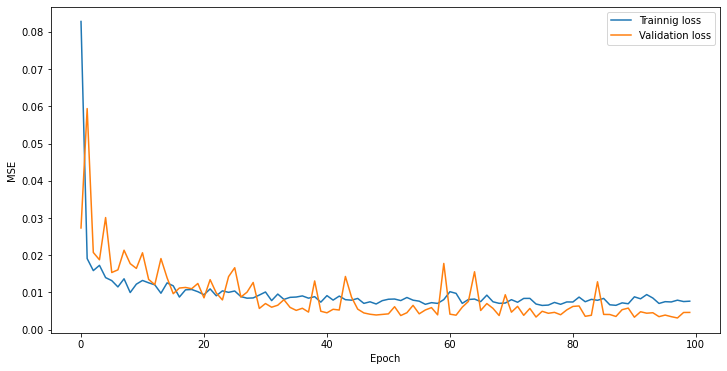

In [17]:
plt.figure(figsize=(12,6))
plt.plot(validation.history["loss"], label="Trainnig loss")
plt.plot(validation.history["val_loss"], label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend();

- Parece que o modelo não está se adaptando adequadamente aos dados durante o treinamento, no entanto, vamos continuar mesmo assim.

### Fazendo a previsão

In [18]:
prev = model.predict(X_test)
prev = scaler.inverse_transform(prev)
prev

23/23 [==============================] - 2s 9ms/step


array([[23.842642 ],
       [24.141556 ],
       [24.287333 ],
       [23.847033 ],
       [23.959106 ],
       [24.444992 ],
       [24.475468 ],
       [24.250692 ],
       [24.578817 ],
       [24.566128 ],
       [24.243544 ],
       [24.562958 ],
       [24.119345 ],
       [22.959694 ],
       [22.959896 ],
       [23.696136 ],
       [23.177069 ],
       [23.850649 ],
       [23.57494  ],
       [23.29623  ],
       [23.601688 ],
       [24.028116 ],
       [23.546164 ],
       [24.853554 ],
       [24.668943 ],
       [25.068884 ],
       [24.79608  ],
       [24.911486 ],
       [25.291048 ],
       [24.363707 ],
       [24.27413  ],
       [24.732061 ],
       [24.939602 ],
       [24.516506 ],
       [25.09164  ],
       [25.270334 ],
       [25.246325 ],
       [24.396072 ],
       [24.95714  ],
       [25.13521  ],
       [24.657753 ],
       [24.338694 ],
       [24.378399 ],
       [23.75164  ],
       [24.429108 ],
       [24.107643 ],
       [23.544159 ],
       [23.80

## 6. Previsão para os Próximos Dez Dias Úteis

### Pegar os ultimos dias (tamanho do step 15 dias)

In [19]:
lenght_test = len(test)
lenght_test

734

In [20]:
days_input_steps = lenght_test-steps
days_input_steps

719

### Converter days_input_steps em um Array

In [21]:
input_steps = test[days_input_steps:]
input_steps = np.array(input_steps).reshape(1,-1)
input_steps

array([[-0.55532547, -0.56921719, -0.5636605 , -0.58033058, -0.5900548 ,
        -0.59422231, -0.60811405, -0.60394651, -0.599779  , -0.60116817,
        -0.61367073, -0.61922742, -0.61922742, -0.59700066, -0.6053357 ]])

### Converter input_steps em uma Lista

In [22]:
list_output_steps = list(input_steps)
list_output_steps = list_output_steps[0].tolist()
list_output_steps

[-0.5553254677699977,
 -0.5692171859726504,
 -0.5636604986915893,
 -0.5803305770950069,
 -0.5900547963970981,
 -0.594222311857894,
 -0.6081140466207811,
 -0.6039465145997508,
 -0.599778999138955,
 -0.6011681709592203,
 -0.6136707339018421,
 -0.6192274211829032,
 -0.6192274211829032,
 -0.5970006554984245,
 -0.6053357029802505]

### Loop para Realizar Previsões para os Próximos 10 Dias

In [23]:
pred_output =[]
i=0
n_future=10
while(i < n_future):

  if (len(list_output_steps)>steps):

    input_steps = np.array(list_output_steps[1:])
    print("{} dia. Valores de entrada -> {}".format(i,input_steps))
    input_steps = input_steps.reshape(1,-1)
    input_steps = input_steps.reshape((1, steps, 1))

    pred = model.predict(input_steps, verbose=0)
    print("{} dia. Valor previsto -> {}".format(i,pred))
    list_output_steps.extend(pred[0].tolist())
    list_output_steps= list_output_steps[1:]

    pred_output.extend(pred.tolist())
    i=i+1

  else:
    input_steps = input_steps.reshape((1, steps, 1))
    pred =model.predict(input_steps, verbose=0)
    print(pred[0])
    list_output_steps.extend(pred[0].tolist())
    print(len(list_output_steps))
    pred_output.extend(pred.tolist())
    i=i+1

print(pred_output)

[-0.60876226]
16
1 dia. Valores de entrada -> [-0.56921719 -0.5636605  -0.58033058 -0.5900548  -0.59422231 -0.60811405
 -0.60394651 -0.599779   -0.60116817 -0.61367073 -0.61922742 -0.61922742
 -0.59700066 -0.6053357  -0.60876226]
1 dia. Valor previsto -> [[-0.60789895]]
2 dia. Valores de entrada -> [-0.5636605  -0.58033058 -0.5900548  -0.59422231 -0.60811405 -0.60394651
 -0.599779   -0.60116817 -0.61367073 -0.61922742 -0.61922742 -0.59700066
 -0.6053357  -0.60876226 -0.60789895]
2 dia. Valor previsto -> [[-0.6080782]]
3 dia. Valores de entrada -> [-0.58033058 -0.5900548  -0.59422231 -0.60811405 -0.60394651 -0.599779
 -0.60116817 -0.61367073 -0.61922742 -0.61922742 -0.59700066 -0.6053357
 -0.60876226 -0.60789895 -0.60807818]
3 dia. Valor previsto -> [[-0.60857797]]
4 dia. Valores de entrada -> [-0.5900548  -0.59422231 -0.60811405 -0.60394651 -0.599779   -0.60116817
 -0.61367073 -0.61922742 -0.61922742 -0.59700066 -0.6053357  -0.60876226
 -0.60789895 -0.60807818 -0.60857797]
4 dia. Valor

### Transformar a Saída

In [24]:
prev = scaler.inverse_transform(pred_output)
prev = np.array(prev).reshape(1,-1)
list_output_prev = list(prev)
list_output_prev = prev[0].tolist()
list_output_prev

[1.405333754686466,
 1.411548341240934,
 1.410258140897846,
 1.4066604256079254,
 1.4026692571372221,
 1.3985133274654062,
 1.3942312524989884,
 1.3899963747516395,
 1.3855860091624805,
 1.3810409169661613]

### Obter as datas de previsão para os próximos dez dias

In [25]:
mglu.reset_index(inplace=True)


In [26]:
predict_dates = pd.date_range(list(mglu["Date"])[-1] + pd.DateOffset(1), periods=10, freq="b").tolist()
predict_dates

[Timestamp('2023-11-07 00:00:00', freq='B'),
 Timestamp('2023-11-08 00:00:00', freq='B'),
 Timestamp('2023-11-09 00:00:00', freq='B'),
 Timestamp('2023-11-10 00:00:00', freq='B'),
 Timestamp('2023-11-13 00:00:00', freq='B'),
 Timestamp('2023-11-14 00:00:00', freq='B'),
 Timestamp('2023-11-15 00:00:00', freq='B'),
 Timestamp('2023-11-16 00:00:00', freq='B'),
 Timestamp('2023-11-17 00:00:00', freq='B'),
 Timestamp('2023-11-20 00:00:00', freq='B')]

### Criando o dataframe de previsões

In [27]:
forecast_dates = []
for i in predict_dates:
  forecast_dates.append(i.date())

df_forecast = pd.DataFrame({"Date": np.array(forecast_dates), "Close": list_output_prev})
df_forecast["Date"] = pd.to_datetime(df_forecast["Date"])

df_forecast=df_forecast.set_index(pd.DatetimeIndex(df_forecast["Date"].values))
df_forecast.drop("Date", axis=1, inplace=True)
df_forecast

,Close
2023-11-07,1.405334
2023-11-08,1.411548
2023-11-09,1.410258
2023-11-10,1.406660
2023-11-13,1.402669
2023-11-14,1.398513
2023-11-15,1.394231
2023-11-16,1.389996
2023-11-17,1.385586
2023-11-20,1.381041


### Gráfico de previsão para os próximos 10 dias

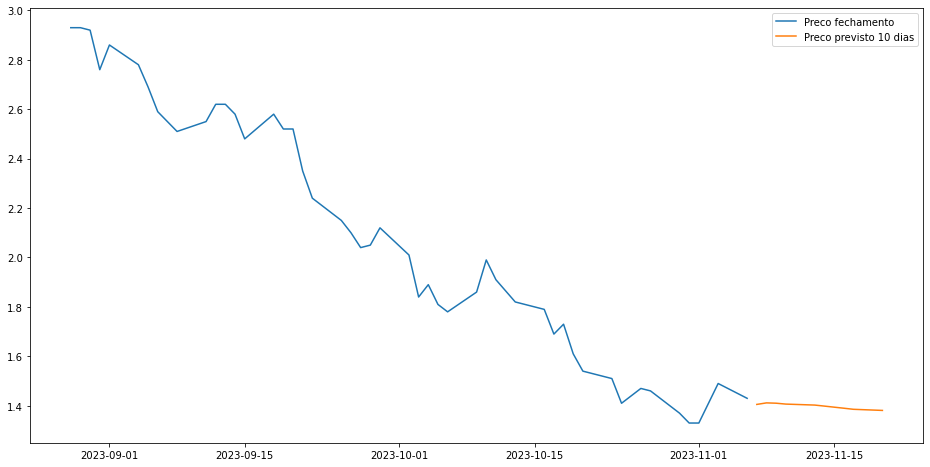

In [29]:
plt.figure(figsize=(16,8))
plt.plot(mglu_fechamento["Close"][2400:])
plt.plot(df_forecast["Close"])
plt.legend(["Preco fechamento", "Preco previsto 10 dias"])
plt.show()

## 6. Conclusão

- O modelo é capaz de fornecer uma visão da previsão para os próximos 10 dias. Prever o preço das ações é uma tarefa notoriamente desafiadora. No entanto, o modelo pode ser capaz de acertar a direção do movimento do preço na maioria das vezes, mas nem sempre.


- É possível   ajustar o número de neurônios, incorporar camadas ocultas adicionais ou aumentar o número de épocas para avaliar seu impacto no desempenho do modelo.


- É viável incorporar informações de outros ativos, como a VIIA3, o Índice Bovespa e a cotação USD/BRL, para verificar se existe correlação entre eles e se influenciam o preço do ativo MGLU3.